In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def process_eval_file(file_name:str):
    
    eva_results = pd.read_excel(f'{file_name}.xlsx')

    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR.replace('[',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.replace(']',''), axis=1)
    eva_results.loc[:,'SR_processed'] = eva_results.apply(lambda row: row.SR_processed.split(','), axis=1)

    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record.replace('[',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.replace(']',''), axis=1)
    eva_results.loc[:,'action_record_processed'] = eva_results.apply(lambda row: row.action_record_processed.split(','), axis=1)

    return eva_results

In [22]:
eval_f_list = []

for i in range(6):
    
    name_prefix = 'modified_experiment_results_para_config_'
    f_num = i+1
    f_name = name_prefix + str(f_num)
    eval_f_list.append(process_eval_file(f_name))

In [23]:
eval_full_file = pd.concat(eval_f_list)

In [26]:
tot_experiments = eval_full_file.shape[0]

In [27]:
eval_full_file.to_excel('modified_experiment_evals_complete.xlsx',index=False)

In [28]:
eval_full_file.loc[:,'positive_SR_idx'] = eval_full_file.apply(lambda row: [idx for idx,val in enumerate(row.SR_processed) if float(val)>0], axis=1)
eval_full_file.positive_SR_idx = eval_full_file.positive_SR_idx.apply(lambda cell: np.nan if len(cell)==0 else cell)
eval_full_file.dropna(subset=['positive_SR_idx'],inplace=True)

eval_full_file.loc[:, 'action_SR_pairs'] = eval_full_file.apply(lambda row: [(int(row.action_record_processed[val]),round(float(row.SR_processed[val]),0)) for val in row.positive_SR_idx ] , axis=1)


In [30]:
action_sr_pair_list_modified = []
for experiment in eval_full_file.action_SR_pairs.values:
    for action_sr_pair in experiment:
        action_sr_pair_list_modified.append(action_sr_pair)
        
action_sr_pairs_modified = np.array(action_sr_pair_list_modified)

action_sr_pairs_modified_df = pd.DataFrame(action_sr_pairs_modified)
action_sr_pairs_modified_df.columns = ['actions','sr']
action_sr_pairs_modified_df.sort_values('actions',inplace=True)

action_sr_pairs_modified_df.loc[:,'pct_sr'] = 1/ tot_experiments

action_sr_pairs_modified_df.loc[:,'cum_pct_sr']  = action_sr_pairs_modified_df.pct_sr.cumsum()
action_sr_pairs_modified_df.head(10)

,actions,sr,pct_sr,cum_pct_sr
65,8322.0,3.0,0.002174,0.002174
56,8960.0,3.0,0.002174,0.004348
14,8970.0,0.0,0.002174,0.006522
6,9054.0,0.0,0.002174,0.008696
50,9075.0,1.0,0.002174,0.010870
1,12384.0,0.0,0.002174,0.013043
79,17487.0,0.0,0.002174,0.015217
72,18275.0,13.0,0.002174,0.017391
67,18319.0,0.0,0.002174,0.019565
71,18378.0,13.0,0.002174,0.021739


In [34]:
action_sr_pairs_modified_df.to_csv('modified_algo_eval_data_for_plot.csv', index=False)

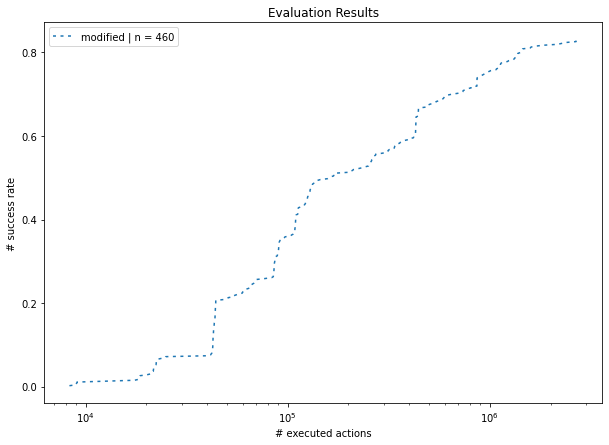

In [33]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(action_sr_pairs_modified_df.actions
        , action_sr_pairs_modified_df.cum_pct_sr
        , linestyle=':'
        , dashes=(2, 3)
        , label = f'modified | n = {tot_experiments}')

plt.ylabel('# success rate')
plt.xlabel('# executed actions')
plt.title('Evaluation Results')
plt.legend(loc = 'upper left')
plt.xscale('log')
plt.show()